### Dealin with imbalanced data

In this notebook I will tackle a credit card fraud data set. This data set is extremly imbalanced as there is well over 200k transactions with only 492 fradulent transactions. 

In [1]:
import tensorflow as tf 
from tensorflow import keras 

import os 
import tempfile

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import BinaryCrossentropy,MeanSquaredError, TruePositives, TrueNegatives, FalseNegatives, FalsePositives,BinaryAccuracy,Precision,Recall


import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
#import data
raw_df = pd.read_csv("creditcard.csv")

In [3]:
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#count each class type to see the imbalance
raw_df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
#Lets take a look at the amount column, it has a wide range and we are going to want to reduce the range to make it easier on the model for training 
#We can achive this by taking the log. 

def preprocess_data(data):
    df = data.copy()
    df['Log_Amount'] = np.log1p(df.pop('Amount'))
    return df 

df = preprocess_data(raw_df)

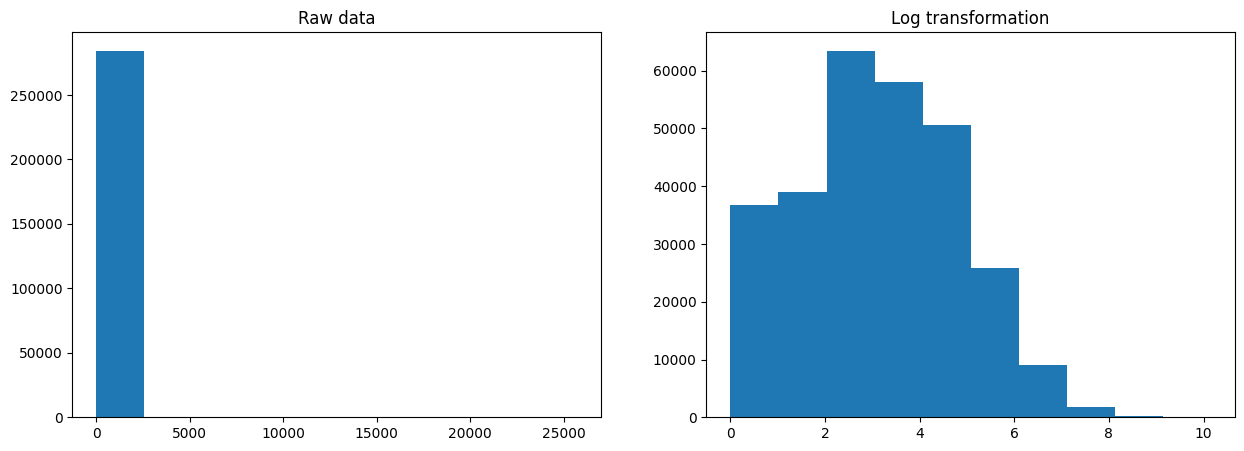

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].hist(raw_df['Amount'])
ax[1].hist(df['Log_Amount'])


ax[0].set_title("Raw data")
ax[1].set_title("Log transformation")

plt.show()
#Now we can see that the amount column has a more normal distribution 

In [7]:
#Now lets split the data into training, validation, and test sets.

def ttv_split(data):

    train, test = train_test_split(data, test_size=0.2)
    train, validation = train_test_split(train, test_size=0.2)
    
    print(train.shape)
    print(test.shape)
    print(validation.shape)
    
    #now create the label np arrays 
    train_labels = np.array(train.pop('Class'))
    bool_train_labels = train_labels !=0 
    val_labels = np.array(validation.pop('Class'))
    test_labels = np.array(test.pop('Class'))
    
    train_feats = np.array(train)
    test_feats = np.array(test)
    val_feats = np.array(validation)

    return train_feats, train_labels, val_feats, val_labels, test_feats, test_labels

In [8]:
train_feats, train_labels, val_feats, val_labels, test_feats, test_labels = ttv_split(df)

(182276, 31)
(56962, 31)
(45569, 31)


In [9]:
#Now lets verrify that the class distribution is the same for all three sets 

print(f'{train_labels.mean():.4f}')
print(f'{test_labels.mean():.4f}')
print(f'{val_labels.mean():.4f}')

0.0017
0.0019
0.0015


In [10]:
scaler = StandardScaler()
train_feats = scaler.fit_transform(train_feats)
test_feats = scaler.fit_transform(test_feats)
val_feats = scaler.fit_transform(val_feats)

#clipping to limit outliers 
train_feats = np.clip(train_feats, -5, 5)
test_feats = np.clip(test_feats, -5, 5)
val_feats = np.clip(val_feats, -5, 5)

In [11]:
#Next lets take a look at the distribution of both positive and negatives 

METRICS = [BinaryCrossentropy(name='cross entropy'),
          MeanSquaredError(name='Brier score'),
          TruePositives(name='tp'),
          TrueNegatives(name='tn'),
          FalseNegatives(name='fn'),
          FalsePositives(name='fp'),
          BinaryAccuracy(name='accuracy'),
          Precision(name='precision'),
          Recall(name='recall')]

def make_model(metrics = METRICS, output_bias = None):
    if output_bias is not None: 
        output_bias = keras.initializers.Constant(output_bias)
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(train_feats.shape[-1],)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss = keras.losses.BinaryCrossentropy(), 
        metrics= METRICS
    )

    return model

In [12]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                496       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [13]:
#testing model before fitting 
model.predict(train_feats[:10])

array([[0.83900493],
       [0.70301497],
       [0.6962264 ],
       [0.74385476],
       [0.83866465],
       [0.7064107 ],
       [0.9416341 ],
       [0.83205664],
       [0.5426779 ],
       [0.80438125]], dtype=float32)

In [14]:
#now to calculate the inital bias so the model wont neglect the minority class 
#few ways of counting class counts 
#neg, pos = np.bincount(raw_df['Class'])
neg, pos = raw_df['Class'].value_counts()
print(neg,pos)

284315 492


In [15]:
inital_bias = np.log([pos/neg])
inital_bias

array([-6.35935934])

In [16]:
#with the intital bias the model should make more reasonable initial guesses. 
#Should be around pos/total = 0.0018 

model = make_model(output_bias=inital_bias)
model.predict(train_feats[:10])

#This allows the model to skip the first few epochs just learning that positive examples are unlikely. 

array([[0.00012876],
       [0.01824061],
       [0.00148632],
       [0.00109043],
       [0.00111485],
       [0.00041128],
       [0.00030611],
       [0.00105384],
       [0.00016587],
       [0.00191726]], dtype=float32)

### Train the model! 

In [17]:
EPOCHS = 100 
BATCH_SIZE = 2048

model = make_model(output_bias=inital_bias)

hist = model.fit(train_feats,
                 train_labels,
                 batch_size=BATCH_SIZE, 
                 epochs=EPOCHS,
                 validation_data=(val_feats, val_labels))

Epoch 1/100
90/90 [==============================] - 3s 21ms/step - loss: 0.0157 - cross entropy: 0.0157 - Brier score: 0.0024 - tp: 56.0000 - tn: 181749.0000 - fn: 260.0000 - fp: 211.0000 - accuracy: 0.9974 - precision: 0.2097 - recall: 0.1772 - val_loss: 0.0060 - val_cross entropy: 0.0060 - val_Brier score: 0.0010 - val_tp: 15.0000 - val_tn: 45498.0000 - val_fn: 55.0000 - val_fp: 1.0000 - val_accuracy: 0.9988 - val_precision: 0.9375 - val_recall: 0.2143
Epoch 2/100
90/90 [==============================] - 1s 9ms/step - loss: 0.0084 - cross entropy: 0.0084 - Brier score: 0.0012 - tp: 129.0000 - tn: 181903.0000 - fn: 187.0000 - fp: 57.0000 - accuracy: 0.9987 - precision: 0.6935 - recall: 0.4082 - val_loss: 0.0047 - val_cross entropy: 0.0047 - val_Brier score: 8.3870e-04 - val_tp: 31.0000 - val_tn: 45490.0000 - val_fn: 39.0000 - val_fp: 9.0000 - val_accuracy: 0.9989 - val_precision: 0.7750 - val_recall: 0.4429
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0

In [18]:
def graph_metric(history, metric):

    fig, ax = plt.subplots()
    ax.plot(history.history[metric])
    ax.set_title(metric)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Count')
    ax.set_xticks(range(0,len(history.history[metric]),10))

    
    plt.show()
    

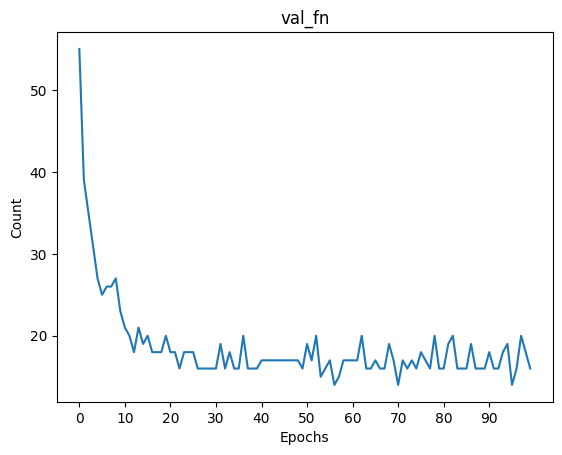

In [19]:
graph_metric(hist, 'val_fn')

## Dealing with the imbalanced data set 

Now that we have a base model trained on imbalanced data, lets try some techniques to improve on the imbalance 

Using under and oversampling we can increase the minority class and or decrease the majority class. This should only be done to the training set in order to keep the testing set in a realistic class distribution. 

In [20]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

#### Oversampling

The over sampler here created more samples from within the underrepresented class. With the over sampler creating copies of the minority class, this can result in the increased probability of over-fitting 

In [21]:
#remember we only want to apply this to the training set. 

#starting with the over sample. 
randomOverSampler = RandomOverSampler()

trainX_over, trainy_over = randomOverSampler.fit_resample(train_feats, train_labels)

print(np.unique(train_labels, return_counts=True))
print(np.unique(trainy_over, return_counts=True))

(array([0, 1], dtype=int64), array([181960,    316], dtype=int64))
(array([0, 1], dtype=int64), array([181960, 181960], dtype=int64))


#### Undersampling 

Undersampling, unsuprisingly does the opposite. It will reduce the majority class to match that of the minority class. This can result in a threat of under-fitting. 

In [22]:
randomUnderSampler = RandomUnderSampler()

trainX_under, trainy_under = randomUnderSampler.fit_resample(train_feats, train_labels)

print(np.unique(train_labels, return_counts=True))
print(np.unique(trainy_under, return_counts=True))

(array([0, 1], dtype=int64), array([181960,    316], dtype=int64))
(array([0, 1], dtype=int64), array([316, 316], dtype=int64))


In this case, undersampling losses way to much detail from the majority class. I wil retrain the model on the oversampled data to see the difference, afterwards I will try my hand at the SMOTE sampling technique to see the difference there aswell. 

In [23]:
over_model = make_model(metrics=METRICS)

over_hist = over_model.fit(trainX_over, trainy_over, 
                           batch_size=BATCH_SIZE, 
                           epochs=EPOCHS,
                           validation_data=(val_feats, val_labels))

Epoch 1/100
178/178 [==============================] - 5s 17ms/step - loss: 0.4291 - cross entropy: 0.3816 - Brier score: 0.1274 - tp: 160214.0000 - tn: 172021.0000 - fn: 21816.0000 - fp: 55438.0000 - accuracy: 0.8113 - precision: 0.7429 - recall: 0.8802 - val_loss: 0.3350 - val_cross entropy: 0.3350 - val_Brier score: 0.0886 - val_tp: 66.0000 - val_tn: 43046.0000 - val_fn: 4.0000 - val_fp: 2453.0000 - val_accuracy: 0.9461 - val_precision: 0.0262 - val_recall: 0.9429
Epoch 2/100
178/178 [==============================] - 2s 11ms/step - loss: 0.2510 - cross entropy: 0.2510 - Brier score: 0.0763 - tp: 163867.0000 - tn: 167961.0000 - fn: 18093.0000 - fp: 13999.0000 - accuracy: 0.9118 - precision: 0.9213 - recall: 0.9006 - val_loss: 0.1992 - val_cross entropy: 0.1992 - val_Brier score: 0.0429 - val_tp: 65.0000 - val_tn: 44358.0000 - val_fn: 5.0000 - val_fp: 1141.0000 - val_accuracy: 0.9749 - val_precision: 0.0539 - val_recall: 0.9286
Epoch 3/100
178/178 [==============================] - 2

In [24]:
#lets comppre models now! 
threshold = 0.8

#get instance probabilities 
preds = model.predict(test_feats)
over_preds = over_model.predict(test_feats)

#convert to class label
preds = (preds[:]>threshold).astype(int)
over_preds = (over_preds[:]>threshold).astype(int)

In [25]:
np.count_nonzero(test_labels)

106

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = round(precision_score(test_labels, preds),4)
over_precision = round(precision_score(test_labels, over_preds),4)

recall = round(recall_score(test_labels, preds),4)
over_recall = round(recall_score(test_labels, over_preds),4)

print("Base Model Precision:",precision, "Base Model Recall:",recall)
print("Over Model Precision:",over_precision, "Over Model Recall:",over_recall)

Base Model Precision: 0.9213 Base Model Recall: 0.7736
Over Model Precision: 0.3368 Over Model Recall: 0.9245


### SMOTE!

Next type of over sampling I will use is SMOTE......explain later!!!!!!!!

In [40]:
from imblearn.over_sampling import SMOTE

In [41]:
SMOTE5 = SMOTE(k_neighbors=5, random_state=42)

trainX_SMOTE, trainy_SMOTE = SMOTE5.fit_resample(train_feats, train_labels)
np.unique(trainy_SMOTE, return_counts=True)

(array([0, 1], dtype=int64), array([181960, 181960], dtype=int64))

In [32]:
SMOTE_model = make_model(metrics=METRICS)

SMOTE_hist = SMOTE_model.fit(trainX_SMOTE, trainy_SMOTE, 
                           batch_size=BATCH_SIZE, 
                           epochs=EPOCHS,
                           validation_data=(val_feats, val_labels))

Epoch 1/100
178/178 [==============================] - 4s 14ms/step - loss: 0.6015 - cross entropy: 0.5382 - Brier score: 0.1707 - tp: 149224.0000 - tn: 152210.0000 - fn: 32806.0000 - fp: 75249.0000 - accuracy: 0.7361 - precision: 0.6648 - recall: 0.8198 - val_loss: 0.3723 - val_cross entropy: 0.3723 - val_Brier score: 0.1117 - val_tp: 62.0000 - val_tn: 39411.0000 - val_fn: 8.0000 - val_fp: 6088.0000 - val_accuracy: 0.8662 - val_precision: 0.0101 - val_recall: 0.8857
Epoch 2/100
178/178 [==============================] - 2s 9ms/step - loss: 0.2856 - cross entropy: 0.2856 - Brier score: 0.0926 - tp: 164040.0000 - tn: 148944.0000 - fn: 17920.0000 - fp: 33016.0000 - accuracy: 0.8600 - precision: 0.8325 - recall: 0.9015 - val_loss: 0.1851 - val_cross entropy: 0.1851 - val_Brier score: 0.0435 - val_tp: 65.0000 - val_tn: 43878.0000 - val_fn: 5.0000 - val_fp: 1621.0000 - val_accuracy: 0.9643 - val_precision: 0.0386 - val_recall: 0.9286
Epoch 3/100
178/178 [==============================] - 2s

In [33]:
#lets comppre models now! 
threshold = 0.80

#get instance probabilities 
preds = model.predict(test_feats)
over_preds = over_model.predict(test_feats)
SMOTE_preds = SMOTE_model.predict(test_feats)


#convert to class label
preds = (preds[:]>threshold).astype(int)
over_preds = (over_preds[:]>threshold).astype(int)
SMOTE_preds = (SMOTE_preds[:]>threshold).astype(int)

In [34]:
precision = round(precision_score(test_labels, preds),4)
over_precision = round(precision_score(test_labels, over_preds),4)
SMOTE_precision = round(precision_score(test_labels, SMOTE_preds),4)

recall = round(recall_score(test_labels, preds),4)
over_recall = round(recall_score(test_labels, over_preds),4)
SMOTE_recall = round(recall_score(test_labels, SMOTE_preds),4)

f1 = round(f1_score(test_labels, preds),4)
over_f1 = round(f1_score(test_labels, over_preds),4)
SMOTE_f1 = round(f1_score(test_labels, SMOTE_preds),4)


print('Class threshold:', threshold)
print("Base Model Precision:",precision, "Base Model Recall:",recall)
print("Over Model Precision:",over_precision, "Over Model Recall:",over_recall)
print("SMOTE Model Precision:",SMOTE_precision, "SMOTE Model Recall:",SMOTE_recall)

print("F1 SCORES: Base:", f1, "Over:", over_f1, "SMOTE:", SMOTE_f1)

Class threshold: 0.8
Base Model Precision: 0.9213 Base Model Recall: 0.7736
Over Model Precision: 0.3368 Over Model Recall: 0.9245
SMOTE Model Precision: 0.4326 SMOTE Model Recall: 0.8774
F1 SCORES: Base: 0.841 Over: 0.4937 SMOTE: 0.5794


I want to visualize the difference the class threshold can make. To do so im going to create a loop to make predictions on a set amount of thresholds. Starting at .5 and working up to .99 or .9.

In [35]:
def thresholdTests(model,X,y, threshold=0.5, step_size=0.01):

    hist_df = pd.DataFrame(columns=['Threshold','Recall', 'Precision', 'F1'])
    count = 0 
    while threshold < 1:
        preds = model.predict(X)
        preds = (preds[:]>threshold).astype(int)

        hist_df.loc[count, 'Threshold'] = threshold
        hist_df.loc[count, 'Recall'] = round(recall_score(y,preds),4)
        hist_df.loc[count, 'Precision'] = round(precision_score(y,preds),4)
        hist_df.loc[count, 'F1'] = round(f1_score(y,preds),4)
        threshold = round(threshold+step_size,2)
        count += 1
        
    return hist_df
    

In [64]:
base_mets = thresholdTests(model=model, X=test_feats, y=test_labels)
over_mets = thresholdTests(model=over_model, X=test_feats, y=test_labels)
SMOTE_mets = thresholdTests(model=SMOTE_model, X=test_feats, y = test_labels)

In [ ]:

def showScores(metric):
    fig, ax = plt.subplots()
    
    ax.plot(base_mets['Threshold'], base_mets[metric], label = 'Base Model')
    ax.plot(over_mets['Threshold'], over_mets[metric], label = 'Over Sampled Model')
    ax.plot(SMOTE_mets['Threshold'], SMOTE_mets[metric], label = 'SMOTE Model')
    
    ax.set_xlabel("Threshold")
    
    ax.set_ylabel(str((metric+ " Score")))
    ax.set_title(str(("Threshold vs. " + metric + " score")))
    ax.legend()
    plt.show()

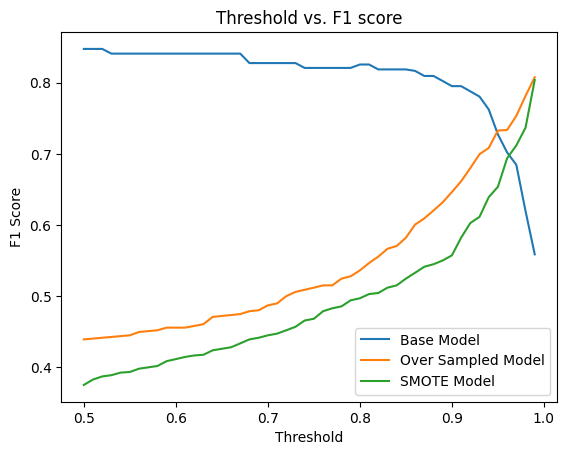

In [212]:
showScores('F1')

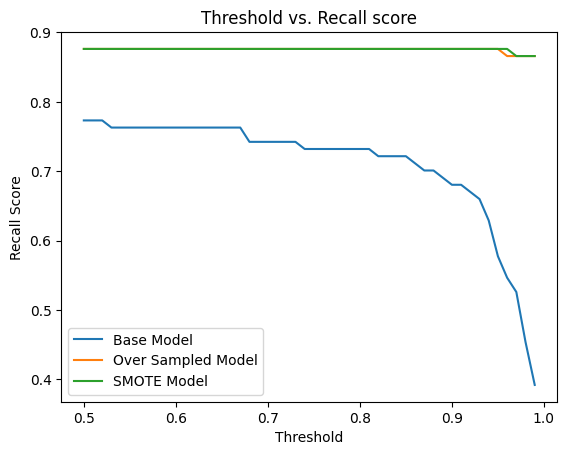

In [200]:
showScores("Recall")

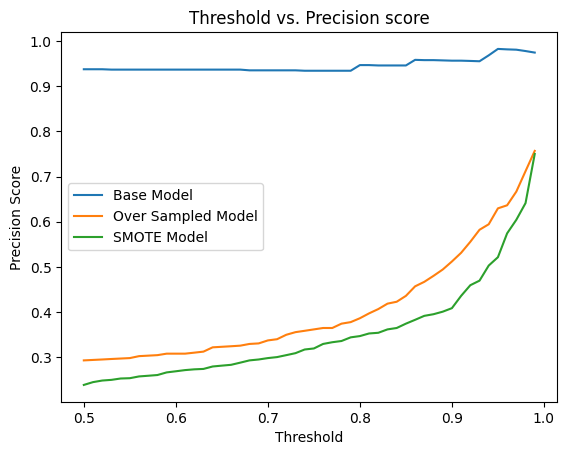

In [201]:
showScores("Precision")

I want to adjust the k_neighbors setting for SMOTE to see when values is best for model performance. 
We started with 5, lets try 4 and 6. 

In [45]:
SMOTE4 = SMOTE(k_neighbors=5, random_state=42)

trainX_SMOTE4, trainy_SMOTE4 = SMOTE4.fit_resample(train_feats, train_labels)
np.unique(trainy_SMOTE4, return_counts=True)

SMOTE4_model = make_model(metrics=METRICS)

SMOTE4_hist = SMOTE4_model.fit(trainX_SMOTE4, trainy_SMOTE4, 
                           batch_size=BATCH_SIZE, 
                           epochs=EPOCHS,
                           validation_data=(val_feats, val_labels))

Epoch 1/100
178/178 [==============================] - 4s 16ms/step - loss: 0.5463 - cross entropy: 0.4875 - Brier score: 0.1687 - tp: 159621.0000 - tn: 134551.0000 - fn: 22409.0000 - fp: 92908.0000 - accuracy: 0.7184 - precision: 0.6321 - recall: 0.8769 - val_loss: 0.4494 - val_cross entropy: 0.4494 - val_Brier score: 0.1369 - val_tp: 67.0000 - val_tn: 40439.0000 - val_fn: 3.0000 - val_fp: 5060.0000 - val_accuracy: 0.8889 - val_precision: 0.0131 - val_recall: 0.9571
Epoch 2/100
178/178 [==============================] - 2s 12ms/step - loss: 0.2821 - cross entropy: 0.2821 - Brier score: 0.0894 - tp: 165253.0000 - tn: 154471.0000 - fn: 16707.0000 - fp: 27489.0000 - accuracy: 0.8786 - precision: 0.8574 - recall: 0.9082 - val_loss: 0.2430 - val_cross entropy: 0.2430 - val_Brier score: 0.0581 - val_tp: 66.0000 - val_tn: 43842.0000 - val_fn: 4.0000 - val_fp: 1657.0000 - val_accuracy: 0.9635 - val_precision: 0.0383 - val_recall: 0.9429
Epoch 3/100
178/178 [==============================] - 2

In [47]:
SMOTE6 = SMOTE(k_neighbors=6, random_state=42)

trainX_SMOTE6, trainy_SMOTE6 = SMOTE6.fit_resample(train_feats, train_labels)
np.unique(trainy_SMOTE6, return_counts=True)

SMOTE6_model = make_model(metrics=METRICS)

SMOTE6_hist = SMOTE6_model.fit(trainX_SMOTE6, trainy_SMOTE6, 
                           batch_size=BATCH_SIZE, 
                           epochs=EPOCHS,
                           validation_data=(val_feats, val_labels))

Epoch 1/100
178/178 [==============================] - 4s 16ms/step - loss: 0.6502 - cross entropy: 0.5805 - Brier score: 0.2005 - tp: 167747.0000 - tn: 105061.0000 - fn: 14283.0000 - fp: 122398.0000 - accuracy: 0.6662 - precision: 0.5781 - recall: 0.9215 - val_loss: 0.5421 - val_cross entropy: 0.5421 - val_Brier score: 0.1776 - val_tp: 65.0000 - val_tn: 36279.0000 - val_fn: 5.0000 - val_fp: 9220.0000 - val_accuracy: 0.7976 - val_precision: 0.0070 - val_recall: 0.9286
Epoch 2/100
178/178 [==============================] - 2s 12ms/step - loss: 0.3089 - cross entropy: 0.3089 - Brier score: 0.1002 - tp: 165982.0000 - tn: 143073.0000 - fn: 15978.0000 - fp: 38887.0000 - accuracy: 0.8492 - precision: 0.8102 - recall: 0.9122 - val_loss: 0.2208 - val_cross entropy: 0.2208 - val_Brier score: 0.0491 - val_tp: 65.0000 - val_tn: 44167.0000 - val_fn: 5.0000 - val_fp: 1332.0000 - val_accuracy: 0.9707 - val_precision: 0.0465 - val_recall: 0.9286
Epoch 3/100
178/178 [==============================] - 

In [54]:
SMOTE10 = SMOTE(k_neighbors=10, random_state=42)

trainX_SMOTE10, trainy_SMOTE10 = SMOTE10.fit_resample(train_feats, train_labels)
np.unique(trainy_SMOTE10, return_counts=True)

SMOTE10_model = make_model(metrics=METRICS)

SMOTE10_hist = SMOTE10_model.fit(trainX_SMOTE10, trainy_SMOTE10, 
                           batch_size=BATCH_SIZE, 
                           epochs=EPOCHS,
                           validation_data=(val_feats, val_labels))

Epoch 1/100
178/178 [==============================] - 4s 17ms/step - loss: 0.5925 - cross entropy: 0.5290 - Brier score: 0.1901 - tp: 170855.0000 - tn: 108636.0000 - fn: 11175.0000 - fp: 118823.0000 - accuracy: 0.6825 - precision: 0.5898 - recall: 0.9386 - val_loss: 0.4769 - val_cross entropy: 0.4769 - val_Brier score: 0.1517 - val_tp: 66.0000 - val_tn: 36798.0000 - val_fn: 4.0000 - val_fp: 8701.0000 - val_accuracy: 0.8090 - val_precision: 0.0075 - val_recall: 0.9429
Epoch 2/100
178/178 [==============================] - 2s 11ms/step - loss: 0.2908 - cross entropy: 0.2908 - Brier score: 0.0967 - tp: 170150.0000 - tn: 137945.0000 - fn: 11810.0000 - fp: 44015.0000 - accuracy: 0.8466 - precision: 0.7945 - recall: 0.9351 - val_loss: 0.1880 - val_cross entropy: 0.1880 - val_Brier score: 0.0421 - val_tp: 64.0000 - val_tn: 44085.0000 - val_fn: 6.0000 - val_fp: 1414.0000 - val_accuracy: 0.9688 - val_precision: 0.0433 - val_recall: 0.9143
Epoch 3/100
178/178 [==============================] - 

In [56]:
SMOTE8 = SMOTE(k_neighbors=8, random_state=42)

trainX_SMOTE8, trainy_SMOTE8 = SMOTE8.fit_resample(train_feats, train_labels)
np.unique(trainy_SMOTE8, return_counts=True)

SMOTE8_model = make_model(metrics=METRICS)

SMOTE8_hist = SMOTE8_model.fit(trainX_SMOTE8, trainy_SMOTE8, 
                           batch_size=BATCH_SIZE, 
                           epochs=EPOCHS,
                           validation_data=(val_feats, val_labels))

Epoch 1/100
178/178 [==============================] - 5s 18ms/step - loss: 0.6653 - cross entropy: 0.5934 - Brier score: 0.2106 - tp: 160621.0000 - tn: 105348.0000 - fn: 21409.0000 - fp: 122111.0000 - accuracy: 0.6495 - precision: 0.5681 - recall: 0.8824 - val_loss: 0.5874 - val_cross entropy: 0.5874 - val_Brier score: 0.2009 - val_tp: 66.0000 - val_tn: 30983.0000 - val_fn: 4.0000 - val_fp: 14516.0000 - val_accuracy: 0.6814 - val_precision: 0.0045 - val_recall: 0.9429
Epoch 2/100
178/178 [==============================] - 2s 11ms/step - loss: 0.3565 - cross entropy: 0.3565 - Brier score: 0.1219 - tp: 169947.0000 - tn: 116261.0000 - fn: 12013.0000 - fp: 65699.0000 - accuracy: 0.7865 - precision: 0.7212 - recall: 0.9340 - val_loss: 0.3120 - val_cross entropy: 0.3120 - val_Brier score: 0.0850 - val_tp: 66.0000 - val_tn: 42089.0000 - val_fn: 4.0000 - val_fp: 3410.0000 - val_accuracy: 0.9251 - val_precision: 0.0190 - val_recall: 0.9429
Epoch 3/100
178/178 [==============================] -

In [48]:
SMOTE_mets = thresholdTests(model=SMOTE_model, X=test_feats, y = test_labels)
SMOTE4_mets = thresholdTests(model=SMOTE4_model, X=test_feats, y = test_labels)
SMOTE6_mets = thresholdTests(model=SMOTE6_model, X=test_feats, y = test_labels)

In [57]:
SMOTE8_mets = thresholdTests(model=SMOTE8_model, X=test_feats, y = test_labels)
SMOTE10_mets = thresholdTests(model=SMOTE10_model, X=test_feats, y = test_labels)

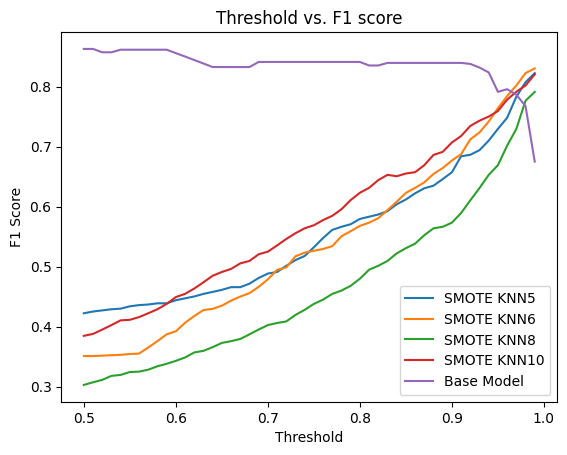

In [65]:
metric = "F1"

fig, ax = plt.subplots()
#ax.plot(SMOTE4_mets['Threshold'], SMOTE4_mets[metric], label = 'SMOTE KNN4')
ax.plot(SMOTE_mets['Threshold'], SMOTE_mets[metric], label = 'SMOTE KNN5')
ax.plot(SMOTE6_mets['Threshold'], SMOTE6_mets[metric], label = 'SMOTE KNN6')
ax.plot(SMOTE8_mets['Threshold'], SMOTE8_mets[metric], label = 'SMOTE KNN8')
ax.plot(SMOTE10_mets['Threshold'], SMOTE10_mets[metric], label = 'SMOTE KNN10')
ax.plot(base_mets['Threshold'], base_mets[metric], label = 'Base Model')


ax.set_xlabel("Threshold")

ax.set_ylabel(str((metric+ " Score")))
ax.set_title(str(("Threshold vs. " + metric + " score")))
ax.legend()
plt.show()

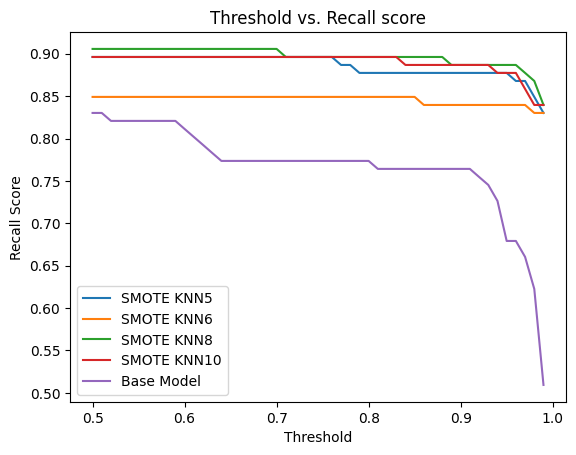

In [66]:
metric = "Recall"

fig, ax = plt.subplots()
#ax.plot(SMOTE4_mets['Threshold'], SMOTE4_mets[metric], label = 'SMOTE KNN4')
ax.plot(SMOTE_mets['Threshold'], SMOTE_mets[metric], label = 'SMOTE KNN5')
ax.plot(SMOTE6_mets['Threshold'], SMOTE6_mets[metric], label = 'SMOTE KNN6')
ax.plot(SMOTE8_mets['Threshold'], SMOTE8_mets[metric], label = 'SMOTE KNN8')
ax.plot(SMOTE10_mets['Threshold'], SMOTE10_mets[metric], label = 'SMOTE KNN10')
ax.plot(base_mets['Threshold'], base_mets[metric], label = 'Base Model')

ax.set_xlabel("Threshold")

ax.set_ylabel(str((metric+ " Score")))
ax.set_title(str(("Threshold vs. " + metric + " score")))
ax.legend()
plt.show()

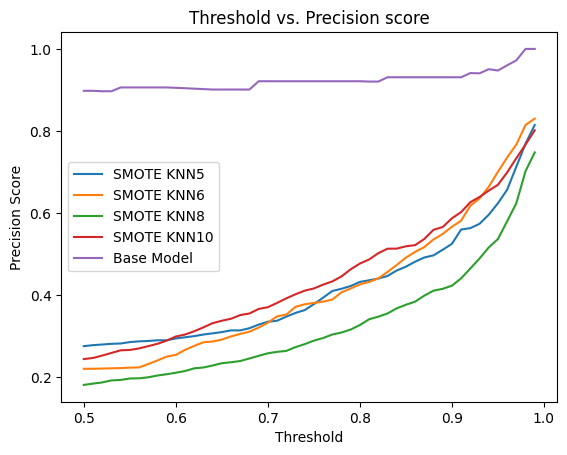

In [67]:
metric = "Precision"

fig, ax = plt.subplots()
#ax.plot(SMOTE4_mets['Threshold'], SMOTE4_mets[metric], label = 'SMOTE KNN4')
ax.plot(SMOTE_mets['Threshold'], SMOTE_mets[metric], label = 'SMOTE KNN5')
ax.plot(SMOTE6_mets['Threshold'], SMOTE6_mets[metric], label = 'SMOTE KNN6')
ax.plot(SMOTE8_mets['Threshold'], SMOTE8_mets[metric], label = 'SMOTE KNN8')
ax.plot(SMOTE10_mets['Threshold'], SMOTE10_mets[metric], label = 'SMOTE KNN10')
ax.plot(base_mets['Threshold'], base_mets[metric], label = 'Base Model')

ax.set_xlabel("Threshold")

ax.set_ylabel(str((metric+ " Score")))
ax.set_title(str(("Threshold vs. " + metric + " score")))
ax.legend()
plt.show()

### Try other model types: Boosted Trees!

In [68]:
from tensorflow.estimator import BoostedTreesClassifier

In [87]:
feature_columns = []

for feat in raw_df.columns:
    feature_columns.append(tf.feature_column.numeric_column(feat))

In [88]:
boosted_tree = BoostedTreesClassifier(
    feature_columns=feature_columns,
    n_batches_per_layer=1, 
    n_trees=100, 
    max_depth=5, 
    learning_rate=0.1
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Griffin\\AppData\\Local\\Temp\\tmpx4xguzgq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
boosted_tree.train(input_fn=)